In [44]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [45]:
class NN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, init=True):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_dim, out_features=hid_dim)
        self.fc2 = nn.Linear(in_features=hid_dim, out_features=hid_dim)
        self.fc3 = nn.Linear(in_features=hid_dim, out_features=out_dim)
        if init:
            self.init_params()

    def forward(self, x):
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

    def init_params(self):
        for n, p in self.named_parameters():
            if "weight" in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

In [46]:
def train(dataloader, model, device, optimizer, criterion, epochs):
    step_losses = []
    model.train()

    for epoch in range(epochs):
        batch_losses = []
        for img, lbl in tqdm(dataloader):
            img, lbl = [x.to(device) for x in [img, lbl]]
            
            optimizer.zero_grad()
            pred = model(img)
            loss = criterion(pred, lbl)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        step_losses.extend(batch_losses)
    return step_losses

In [47]:
mean, std = 0.1307, 0.3081
bs, nw = 128, 32

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (std, ))
])

train_dataset = torchvision.datasets.MNIST(".", train = True, transform = train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size = bs, shuffle = True, num_workers = nw)

in_dim = 28 * 28
hid_dim = 256
out_dim = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NN(in_dim, hid_dim, out_dim)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters())

sgd_loss = train(train_loader, model, device, optimizer, criterion, 5)

100%|██████████| 469/469 [00:02<00:00, 162.11it/s]


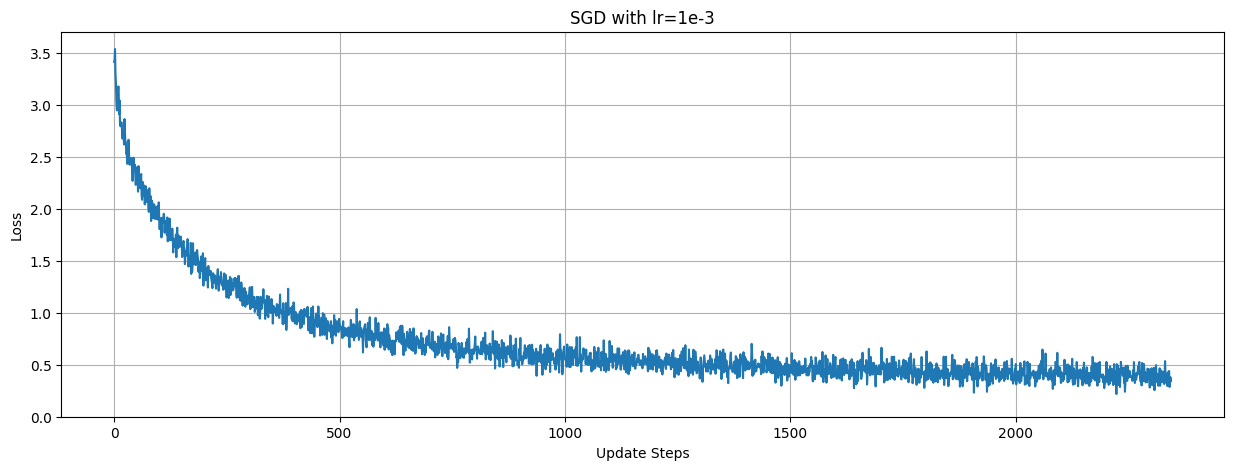

In [49]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

plot_loss(sgd_loss, 'SGD with lr=1e-3')
plt.savefig(os.path.join(os.path.abspath(os.getcwd()), "images", 'sgd.png'), dpi=300)